# Setup

In [1]:
import getpass
import numpy as np
import matplotlib.pyplot as plt

import axs
import pyspark.sql.functions as sparkfunc

import dipper

In [2]:
%matplotlib notebook

In [3]:
def spark_start(local_dir):
    from pyspark.sql import SparkSession
    
    spark = (
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", local_dir)
            .config('spark.master', "local[6]")
            #.config('spark.master', "local[24]")
            .config('spark.driver.memory', '8G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '4G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "6G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={local_dir}")
            .enableHiveSupport()
            .getOrCreate()
    )   

    return spark

username = getpass.getuser()
spark_session = spark_start(f"/epyc/users/{username}/spark-tmp/")

catalog = axs.AxsCatalog(spark_session)

In [4]:
spark_session

# Find the best "dippers"

In [191]:
# Load a small catalog where we have used loose selection cuts
# to find dippers.
wtf = catalog.load('wtf_full_oct19_6')

In [192]:
# Recalculate the dipper scores. Note, Spark uses lazy evaluation, so
# this doesn't actually do anything until we do something with
# the results.
rescored_wtf = (
    wtf
    .drop('dip')
    .select(
        '*',
        dipper.build_measure_dip_udf()(
            wtf['mjd_g'],
            wtf['mag_g'],
            wtf['magerr_g'],
            wtf['xpos_g'],
            wtf['ypos_g'],
            wtf['catflags_g'],
            wtf['mjd_r'],
            wtf['mag_r'],
            wtf['magerr_r'],
            wtf['xpos_r'],
            wtf['ypos_r'],
            wtf['catflags_r'],
            wtf['mjd_i'],
            wtf['mag_i'],
            wtf['magerr_i'],
            wtf['xpos_i'],
            wtf['ypos_i'],
            wtf['catflags_i'],
        ).alias('dip'),
    )
    .where(
        (sparkfunc.col("dip.significant_observation_count") >= 3)
        & (sparkfunc.col("dip.core_not_significant_fraction") <= 0.2)
        & (sparkfunc.col("dip.significant_width") >= 1)
        & (sparkfunc.col("dip.significance") >= 5)
        & (sparkfunc.col("dip.ref_pull_std") < 1.5)
        & (sparkfunc.col("dip.ref_large_pull_fraction") < 0.1)
        & (sparkfunc.col("dip.max_gap_fraction") < 0.8)
    )
)

In [193]:
%%time

# Get the best dippers
print(f"Initial dataset: {wtf.count()} light curves.")
#best_dippers = rescored_wtf.sort(rescored_wtf['dip.significance'].desc()).head(1000)
best_dippers = rescored_wtf.sort(rescored_wtf['dip.significance'].desc()).collect()
print(f"Found {len(best_dippers)} dippers")

Initial dataset: 88092 light curves.
Found 781 dippers
CPU times: user 656 ms, sys: 240 ms, total: 896 ms
Wall time: 8min 53s


In [30]:
# Save the small set to an AXS table.
#catalog.save_axs_table(rescored_wtf, 'one_dip_to_rule_them_all_v1', repartition=True)

In [31]:
%matplotlib inline

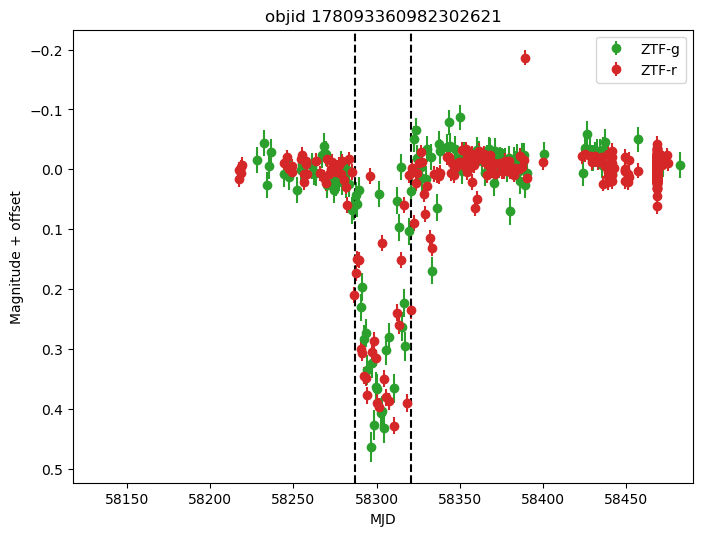

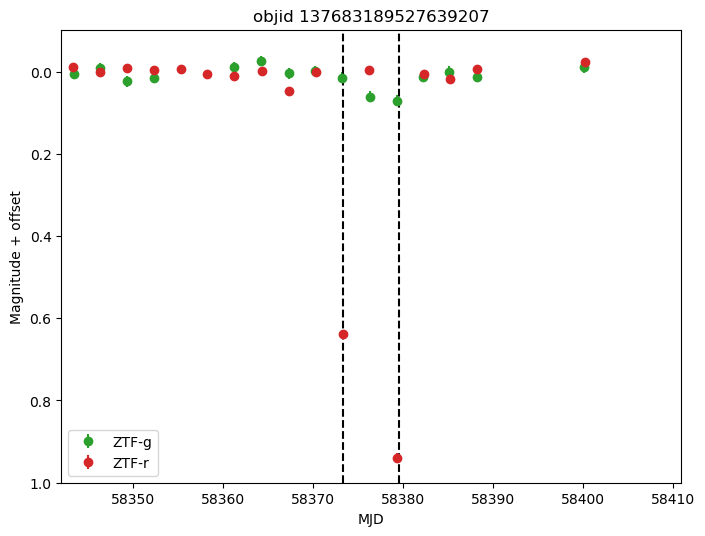

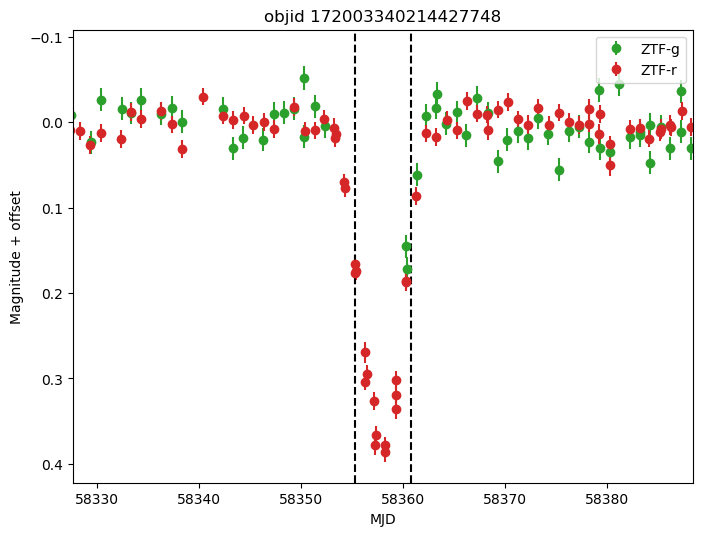

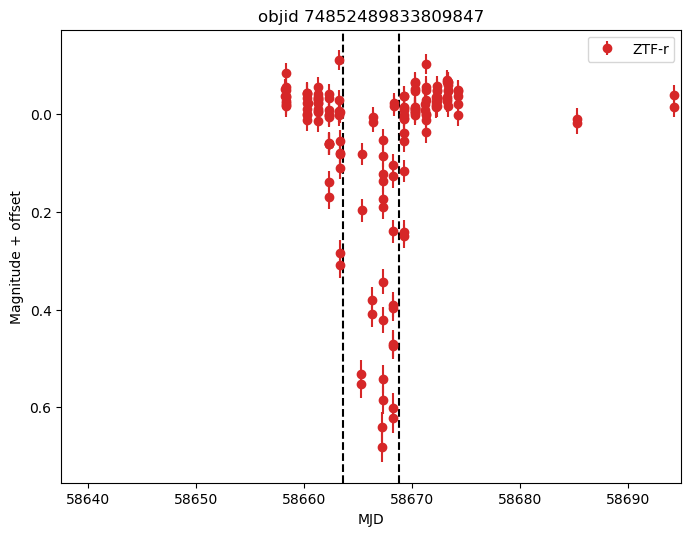

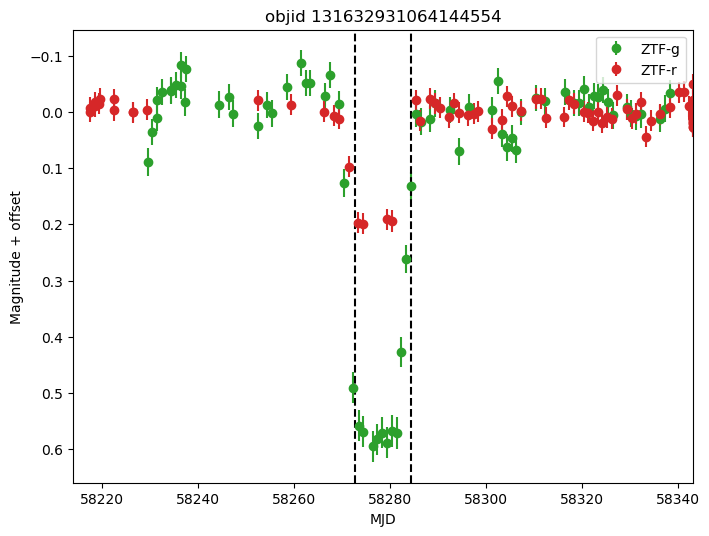

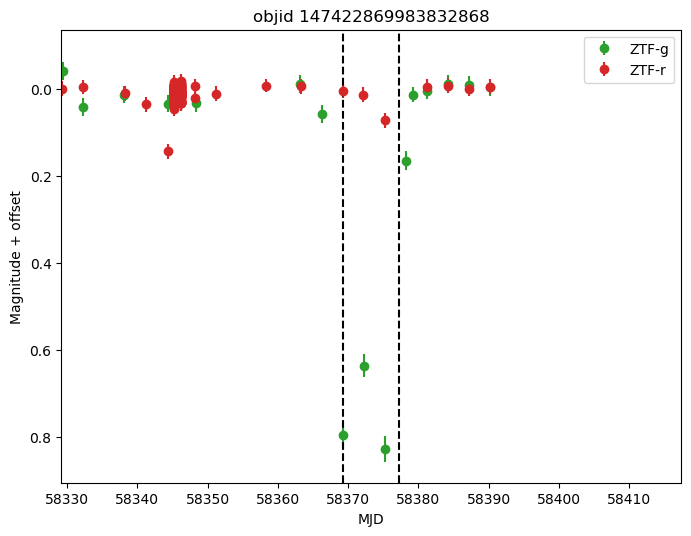

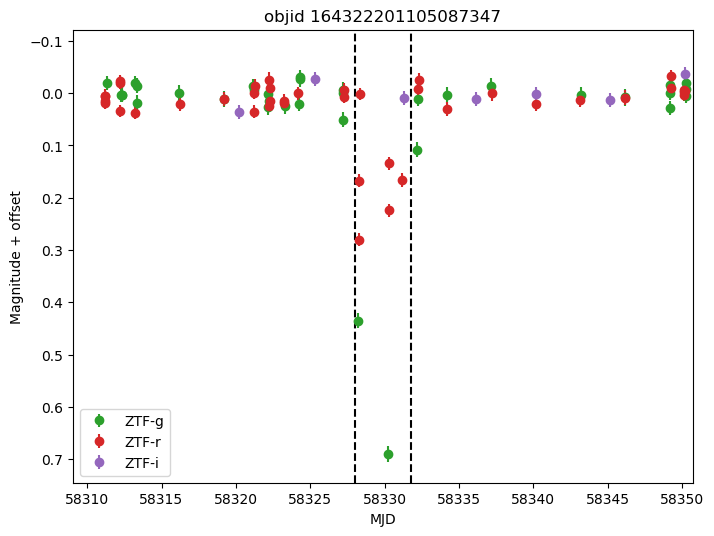

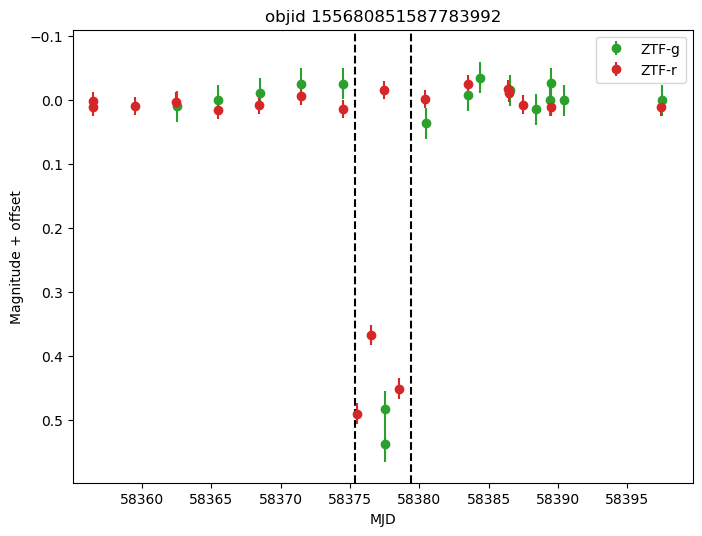

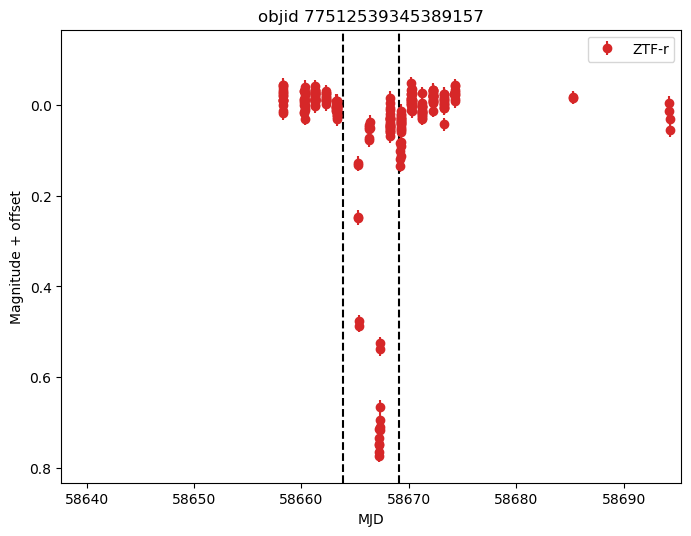

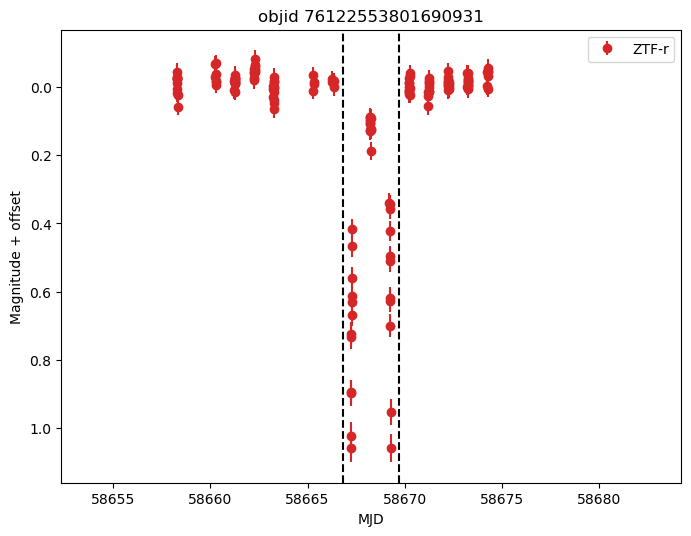

In [32]:
# Plot a light curve
for i in range(10):
    dipper.plot_light_curve(best_dippers[i], verbose=False, zoom=True)
    #dipper.plot_dip(best_dippers[i])

In [155]:
%matplotlib inline

In [ ]:
# Show an interactive display of the light curves
dipper.plot_interactive(best_dippers)

# Rerun over the full ZTF dataset

Warning! This takes a long time to run. With the latest dipper code, it is ~2000 core hours. It is recommended to increase the number of cores that spark is running on before you execute this (e.g, in the spark setup change `.config('spark.master', "local[6]")` which uses 6 cores to something larger. It is also possible to run on AWS with hundreds or even thousands of cores.

In [6]:
# Load the full ZTF dataset
ztf = catalog.load('ztf_oct19')

In [ ]:
%%time

# Run the dip detection query on the full ZTF dataset on spark
result = (
    ztf
    .exclude_duplicates()
    .where(
        (ztf["nobs_g"] >= 10)
        | (ztf["nobs_r"] >= 10)
        | (ztf["nobs_i"] >= 10)
    )
    .select(
        '*',
        dipper.build_measure_dip_udf()(
            ztf['mjd_g'],
            ztf['mag_g'],
            ztf['magerr_g'],
            ztf['xpos_g'],
            ztf['ypos_g'],
            ztf['catflags_g'],
            ztf['mjd_r'],
            ztf['mag_r'],
            ztf['magerr_r'],
            ztf['xpos_r'],
            ztf['ypos_r'],
            ztf['catflags_r'],
            ztf['mjd_i'],
            ztf['mag_i'],
            ztf['magerr_i'],
            ztf['xpos_i'],
            ztf['ypos_i'],
            ztf['catflags_i']
        ).alias('dip'),
    )
    .where(
        (sparkfunc.col("dip.significant_observation_count") >= 3)
        & (sparkfunc.col("dip.significance") >= 5)
        & (sparkfunc.col("dip.ref_pull_std") < 2.)
        & (sparkfunc.col("dip.ref_large_pull_fraction") < 0.2)
        & (sparkfunc.col("dip.max_gap") < 3.)
    )
    .write.parquet('./query_wtf_7.parquet')
)

In [ ]:
# Save the result to an AXS table
parquet_wtf = spark_session.read.parquet('./query_wtf_7.parquet')
catalog.save_axs_table(parquet_wtf, 'wtf_full_oct19_6', repartition=True)

In [62]:
# Save the result to an AXS table
parquet_wtf = spark_session.read.parquet('../../edata/ztf_boyajian/s3_test_wtf/')
catalog.save_axs_table(parquet_wtf, 'wtf_full_oct19_6', repartition=True)

# Tests of the dipper finder on simulations

In [33]:
def simulate_light_curve(N=1000, err=0.02, width=5, depth=1):
    x = np.sort(np.random.uniform(0, 1000, N))
    y = np.random.normal(size=N) * err
    yerr = np.ones(N) * err
    y += depth * np.exp(-(x-500)**2 / 2 / width**2)
    
    return x, y, yerr

In [190]:
import importlib
import dipper
importlib.reload(dipper)

<module 'dipper' from '/astro/users/kyboone/boyajian/ZTF_Boyajian/dipper.py'>

In [133]:
%matplotlib inline

{'integral': 20.326396918937963,
 'integral_uncertainty': 1.1294318046730214,
 'significance': 17.997011271364542,
 'start_mjd': 472.1157850405862,
 'center_mjd': 489.4624265762761,
 'end_mjd': 506.809068111966,
 'length': 34.69328307137977,
 'window_start_mjd': 419.24078147016786,
 'window_end_mjd': 558.5687283583034,
 'max_gap': 49.805105769548845,
 'max_gap_fraction': 1.4355835297304447,
 'ref_observation_count': 98,
 'ref_pull_std': 0.954956810872181,
 'ref_large_pull_fraction': 0.0,
 'dip_observation_count': 1,
 'significant_observation_count': 1,
 'core_not_significant_fraction': 0.0,
 'significant_width': 0.0}

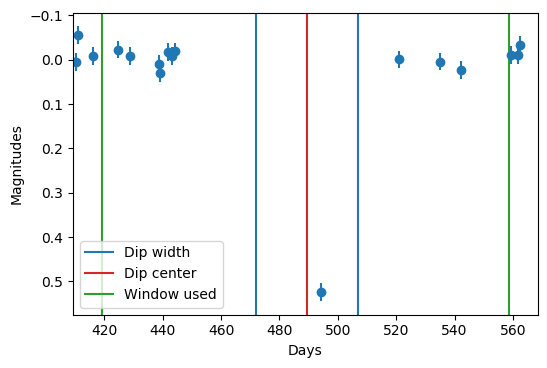

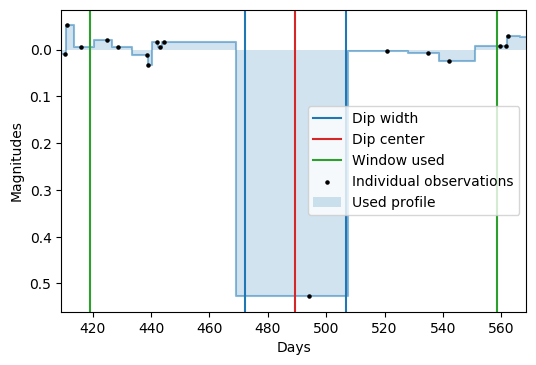

In [185]:
# Basic sim
x, y, yerr = simulate_light_curve(100)

res = dipper.measure_dip(x, y, yerr)

def annotate_plot():
    plt.axvline(res['start_mjd'], label='Dip width')
    plt.axvline(res['center_mjd'], c='C3', label='Dip center')
    plt.axvline(res['end_mjd'])
    plt.axvline(res['window_start_mjd'], c='C2', label='Window used')
    plt.axvline(res['window_end_mjd'], c='C2')

    plt.xlim(res['window_start_mjd'] - 10, res['window_end_mjd'] + 10)
    plt.gca().invert_yaxis()

    plt.legend()
    plt.xlabel('Days')
    plt.ylabel('Magnitudes')

plt.figure(dpi=100)
plt.errorbar(x, y, yerr, fmt='o')
annotate_plot()

res_parsed = dipper.measure_dip(x, y, yerr, return_parsed_observations=True)
if len(res_parsed) > 0:
    mjd = res_parsed['parsed_mjd']
    mag = res_parsed['parsed_mag']
    magerr = res_parsed['parsed_magerr']

    plt.figure(dpi=100)
    plt.scatter(mjd, mag, s=5, c='k', zorder=3, label='Individual observations')
    plt.fill_between(mjd, mag, step='mid', alpha=0.2, label='Used profile')
    plt.plot(mjd, mag, drawstyle='steps-mid', alpha=0.5)
    annotate_plot()

res

In [178]:
np.argmax(np.ones(5) > 2)

0

In [128]:
x = np.ones(10, dtype=bool)
x[4:7] = 1
print(x)
print(np.convolve(x, [1, 1, 1], mode='same') > 0)

[ True  True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True]


{'integral': 14.401105403843287, 'integral_uncertainty': 0.700576512522184, 'significance': 20.556077953565808, 'start_mjd': 487.0979426192211, 'center_mjd': 499.92312701574707, 'end_mjd': 507.6252321396711, 'length': 20.527289520449983, 'window_start_mjd': 429.2137739563853, 'window_end_mjd': 568.5816935544924, 'max_gap': 9.644758835606126, 'max_gap_fraction': 0.4698505774957619, 'ref_observation_count': 92, 'ref_pull_std': 0.8643136527679924, 'ref_large_pull_fraction': 0.0, 'dip_observation_count': 5, 'significant_observation_count': 5, 'core_not_significant_fraction': 0.0, 'significant_width': 12.459353178030142}


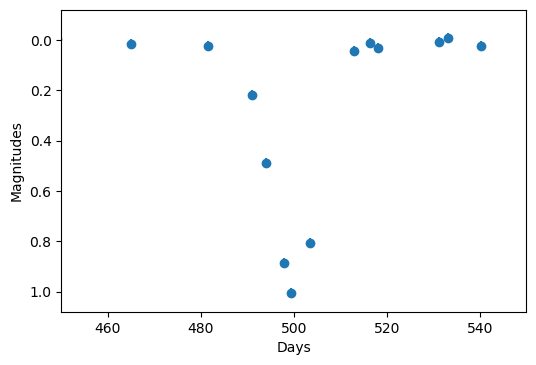

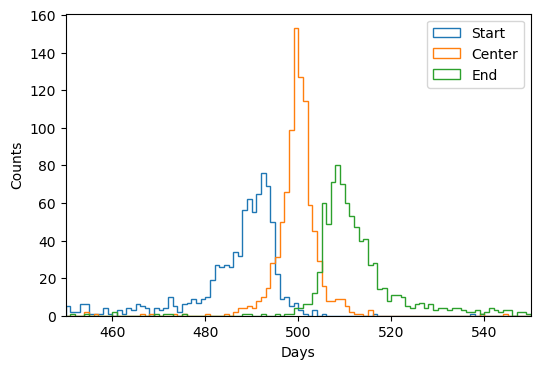

In [41]:
# Simulate a lot of poorly sampled dips, and see how well we recover them.

all_start = []
all_center = []
all_end = []

for i in range(1000):
    # Basic sim
    x, y, yerr = simulate_light_curve(N=100)
    
    res = dipper.measure_dip(x, y, yerr)
    
    if i == 0:
        # Show the first light curve
        plt.figure(dpi=100)
        plt.errorbar(x, y, yerr, fmt='o')
        plt.gca().invert_yaxis()
        plt.xlim(450, 550)
        plt.xlabel('Days')
        plt.ylabel('Magnitudes')
        print(res)

    all_start.append(res['start_mjd'])
    all_center.append(res['center_mjd'])
    all_end.append(res['end_mjd'])
    
plt.figure(dpi=100)
plt.hist(all_start, 100, (450, 550), histtype='step', label='Start')
plt.hist(all_center, 100, (450, 550), histtype='step', label='Center')
plt.hist(all_end, 100, (450, 550), histtype='step', label='End')
plt.xlim(450, 550)
plt.xlabel('Days')
plt.ylabel('Counts')
plt.legend()

# Select a random subset of light curves

In [5]:
# Load the full ZTF dataset
ztf = catalog.load('ztf_oct19')

In [ ]:
%%time

# Number of light curves to target
N = 10

base_sample = (
    ztf
    .exclude_duplicates()
    .where(
        (ztf["nobs_g"] >= 10)
        | (ztf["nobs_r"] >= 10)
        | (ztf["nobs_i"] >= 10)
    )
)

count = base_sample.count()
frac = N / count

# Run the dip detection query on the full ZTF dataset on spark
result = (
    base_sample
    .select(
        ztf['mjd_g'],
        ztf['mag_g'],
        ztf['magerr_g'],
        ztf['mjd_r'],
        ztf['mag_r'],
        ztf['magerr_r'],
        ztf['mjd_i'],
        ztf['mag_i'],
        ztf['magerr_i'],
    )
    .sample(False, frac)
    .toPandas()
)